In [1]:
import sys
sys.path.append("../")
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from net import Net

In [3]:
bk_lvl = 50
print("black level of the sensor: ", bk_lvl)

black level of the sensor:  50


In [4]:
rIm=read_raw("../static_videos/lowlight3_frame16_bunny_3.raw", frame =16)
rIm = rIm[:, :2048, :3584]
ref_idx = 0

In [5]:
model = Net().cuda()
model.eval()

Net(
  (pwc_net): Network(
    (netExtractor): Extractor(
      (netOne): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.1)
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.1)
        (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): LeakyReLU(negative_slope=0.1)
      )
      (netTwo): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.1)
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.1)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): LeakyReLU(negative_slope=0.1)
      )
      (netThr): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_

In [6]:
import time
with torch.no_grad():
    start = time.time()
    ref = rIm[ref_idx]
    ref_t = torch.from_numpy(np.ascontiguousarray(ref.copy()))
    final = rIm[ref_idx].copy()
    for idx in range(1, 16):
        print("merge {}th raw frame...".format(idx))
        alt = rIm[idx]
        alt_t = torch.from_numpy(np.ascontiguousarray(alt.copy()))
        inputs = torch.stack([ref_t, alt_t], dim = 0).unsqueeze(0)
        outputs = model(inputs.float().cuda())
        img = outputs[0][0].detach().cpu().numpy()#.transpose(1, 2, 0)
        merged_frame = img.astype(ref.dtype)
        final += merged_frame
    print("elapsed time: {:.2f}".format(time.time() - start))

merge 1th raw frame...


/home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


merge 2th raw frame...
merge 3th raw frame...
merge 4th raw frame...
merge 5th raw frame...
merge 6th raw frame...
merge 7th raw frame...
merge 8th raw frame...
merge 9th raw frame...
merge 10th raw frame...
merge 11th raw frame...
merge 12th raw frame...
merge 13th raw frame...
merge 14th raw frame...
merge 15th raw frame...
elapsed time: 12.26


In [7]:
rIm_merge = final - bk_lvl* rIm.shape[0]
rIm_merge = rIm_merge.astype(np.int16)
rIm_merge = np.clip(rIm_merge, 0, 1023)
print_stat("rIm_merge", rIm_merge)
bit_length = np.log2(rIm_merge.max())
print("bit_length", bit_length)

rIm_merge  shape:  (2048, 3584) dtype: int16
rIm_merge stat: max: 401, min: 0, mean: 98.16479001726422, std: 55.106007951209726
bit_length 8.647458


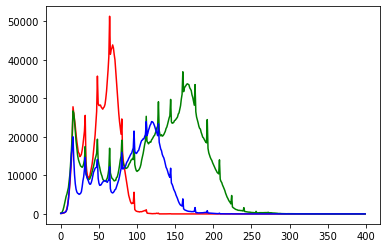

In [8]:
plot_histogram(rIm_merge, bit_length)

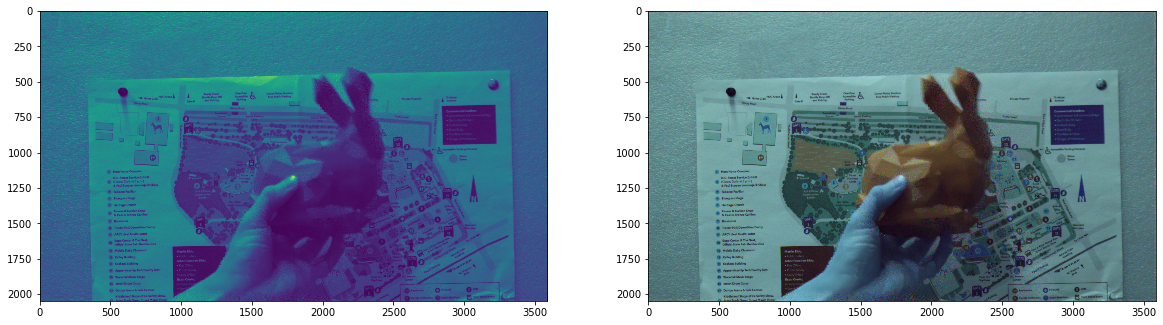

In [9]:
rgbIm_merge = demosaic(rIm_merge)
rgbIm_adj_merge = adjustColor(rgbIm_merge,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rIm_merge)
ax[1].imshow(rgbIm_adj_merge)
plt.show()

rIm_single  shape:  (2048, 3584) dtype: int16
rIm_single stat: max: 27, min: 0, mean: 6.548732621329171, std: 3.5766085926180717
bit_length 4.7548876


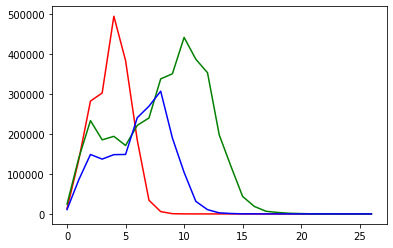

In [10]:
rIm_single = rIm[ref_idx] - bk_lvl
rIm_single = np.clip(rIm_single, 0, 1023)
print_stat("rIm_single",rIm_single)
bit_length = np.log2(rIm_single.max())
print("bit_length", bit_length)
plot_histogram(rIm_single, bit_length)

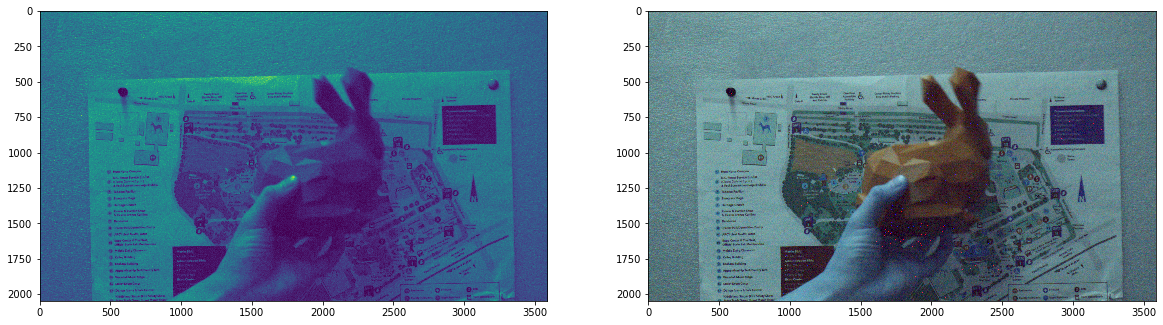

In [11]:
rgbIm_single = demosaic(rIm_single)
rgbIm_adj_single = adjustColor(rgbIm_single,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rIm_single)
ax[1].imshow(rgbIm_adj_single)
plt.show()

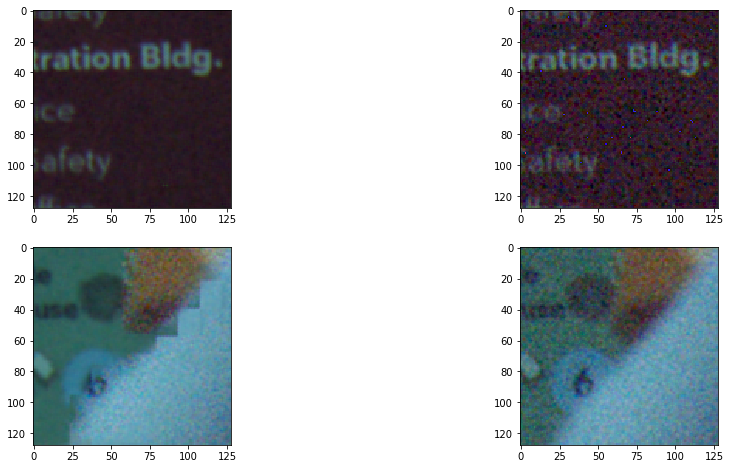

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
ax[0][0].imshow(rgbIm_adj_merge[1732:1828+32, 1020+32:1148+32])
ax[0][1].imshow(rgbIm_adj_single[1732:1828+32, 1020+32:1148+32])
ax[1][0].imshow(rgbIm_adj_merge[1332:1332+128, 1532-128:1532])
ax[1][1].imshow(rgbIm_adj_single[1332:1332+128, 1532-128:1532])
plt.show()